Data shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8024 - loss: 0.4681 - val_accuracy: 0.8933 - val_loss: 0.2664
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9021 - loss: 0.2845 - val_accuracy: 0.9065 - val_loss: 0.2277
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9176 - loss: 0.2457 - val_accuracy: 0.9279 - val_loss: 0.1858
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9281 - loss: 0.2216 - val_accuracy: 0.9340 - val_loss: 0.1751
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9362 - loss: 0.2025 - val_accuracy: 0.9379 - val_loss: 0.1631
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9383 - loss: 0.1907 - val_accuracy: 0.9473 - val_loss: 0.1480
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9421 - loss: 0.1820 - val_accuracy: 0.9476 - val_loss: 0.1434
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9448 - loss: 0.1764 - val_accuracy: 0.

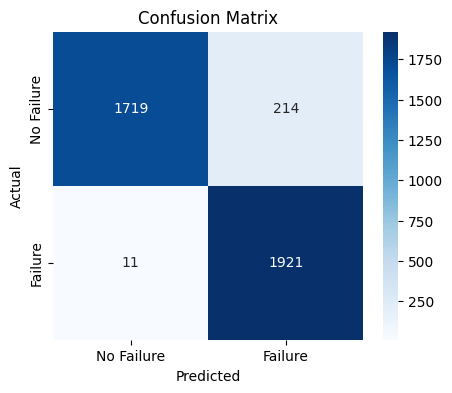

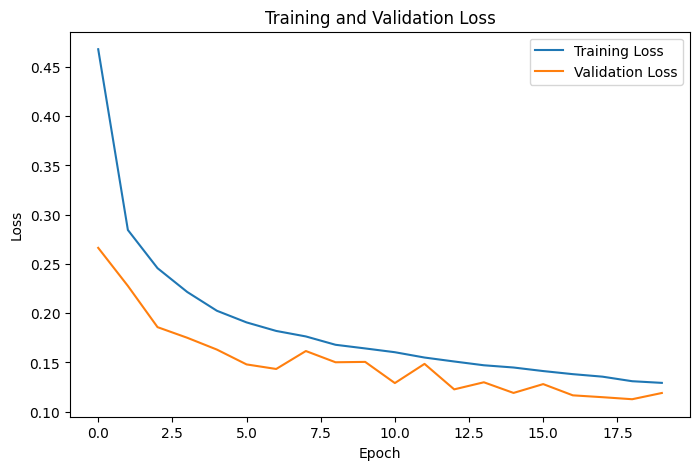

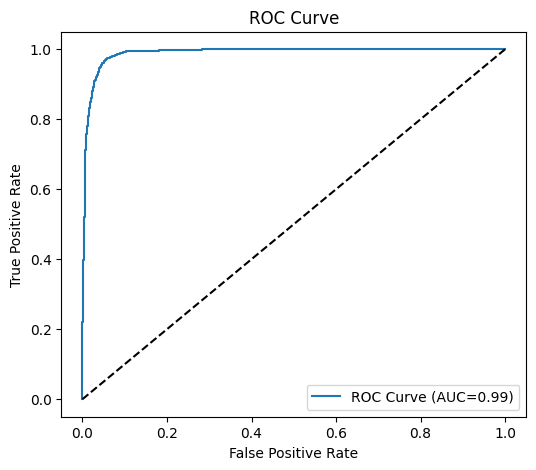

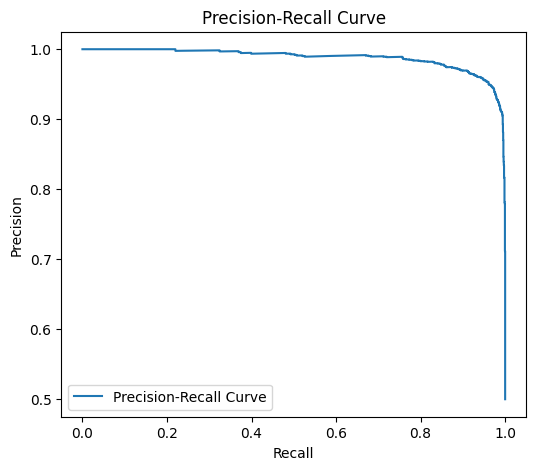

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Example prediction probability of failure: 1.0000


In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# 2. Load Data
df = pd.read_csv('ai4i2020.csv')
print("Data shape:", df.shape)
display(df.head())

# 3. Preprocessing
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = df['Machine failure']
X = pd.get_dummies(X, columns=['Type'], drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. SMOTE Oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 6. Build Improved ANN Model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. Use Class Weights
class_weight = {0: 1.0, 1: 1.5}

# 8. Train Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1,
    class_weight=class_weight
)

# 9. Predict and Tune Threshold
y_pred_prob = model.predict(X_test)
threshold = 0.3  # Lower threshold for higher recall
y_pred = (y_pred_prob > threshold).astype(int)

# 10. Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 11. Training History
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 12. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 13. Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 14. Example Prediction
example = X_test[0].reshape(1, -1)
pred_example = model.predict(example)[0][0]
print(f"Example prediction probability of failure: {pred_example:.4f}")